In [1]:
!mkdir -p ./datasets/facades/
!wget http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/facades.tar.gz -O ./datasets/facades.tar.gz
!tar -zxvf ./datasets/facades.tar.gz -C ./datasets/

--2020-09-08 16:17:26--  http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/facades.tar.gz
Resolving efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)... 128.32.189.73
Connecting to efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)|128.32.189.73|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30168306 (29M) [application/x-gzip]
Saving to: ‘./datasets/facades.tar.gz’

./datasets/facades. 100%[===================>]  28.77M  2.79MB/s    in 10s     

2020-09-08 16:17:36 (2.83 MB/s) - ‘./datasets/facades.tar.gz’ saved [30168306/30168306]

facades/
facades/test/
facades/test/27.jpg
facades/test/5.jpg
facades/test/72.jpg
facades/test/1.jpg
facades/test/10.jpg
facades/test/100.jpg
facades/test/101.jpg
facades/test/102.jpg
facades/test/103.jpg
facades/test/104.jpg
facades/test/105.jpg
facades/test/106.jpg
facades/test/11.jpg
facades/test/12.jpg
facades/test/13.jpg
facades/test/14.jpg
facades/test/15.jpg
facades/test/16.jpg
facades/test/17.jpg
facades/te

In [2]:
#CUDA_LAUNCH_BLOCKING=1

In [3]:
import os
import datetime
import numpy as np 
import pandas as pd 
import time

In [4]:
from PIL import Image
import matplotlib.pyplot as plt
from IPython import display

In [5]:
def create_dataset(dir,outdir):
  fnames = os.listdir(dir)
  if not os.path.isdir(outdir):
    os.mkdir(outdir)
    os.mkdir(os.path.join(outdir,'input'))
    os.mkdir(os.path.join(outdir,'target'))
  for fname in fnames:
    fpath = os.path.join(dir,fname)
    with Image.open(fpath) as img:
      w,h = img.size
      im1 = img.crop((0,0,w//2,h))
      im2 = img.crop((w//2,0,w,h))
      outpath1 = os.path.join(outdir,'input',fname)
      outpath2 = os.path.join(outdir,'target',fname)
      im1.save(outpath2)
      im2.save(outpath1)

In [6]:
train_dir = './datasets/facades/train/'
test_dir = './datasets/facades/test/'
val_dir = './datasets/facades/val/'

outdir = './data/'
if not os.path.isdir(outdir):
  os.mkdir(outdir)
outdir_facades = os.path.join(outdir,'facades')
if not os.path.isdir(outdir_facades):
  os.mkdir(outdir_facades)

train_outdir = './data/facades/train/'
test_outdir = './data/facades/test/'
val_outdir = './data/facades/val/'

create_dataset(train_dir,train_outdir)
create_dataset(test_dir,test_outdir)
create_dataset(val_dir,val_outdir)

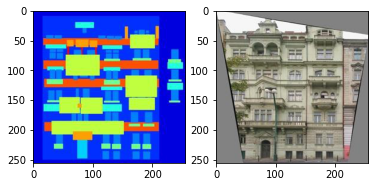

In [7]:
# check if data is accessible
input_path = './data/facades/train/input/100.jpg'
target_path = './data/facades/train/target/100.jpg'

plt.figure()
plt.subplot(1,2,1)
img1 = Image.open(input_path)
plt.imshow(img1)
plt.subplot(1,2,2)
img2 = Image.open(target_path)
plt.imshow(img2)

In [8]:
import torch 
from torch import nn
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms,datasets 

In [9]:
def make_dataset(dir, max_dataset_size=float("inf")):
    images = []
    assert os.path.isdir(dir), '%s is not a valid directory' % dir

    for root, _, fnames in sorted(os.walk(dir)):
        for fname in fnames:
            path = os.path.join(root, fname)
            images.append(path)
    return images[:min(max_dataset_size, len(images))]

In [10]:
transform = transforms.Compose([transforms.ToTensor()])

In [11]:
class pix2pixDataset(Dataset):

    def __init__(self, dir):

        self.dir_A = os.path.join(dir, 'input')  # create a path '/path/to/data/trainA'
        self.dir_B = os.path.join(dir, 'target')  # create a path '/path/to/data/trainB'

        self.A_paths = sorted(make_dataset(self.dir_A))   # load images from '/path/to/data/trainA'
        self.B_paths = sorted(make_dataset(self.dir_B))    # load images from '/path/to/data/trainB'
        self.A_size = len(self.A_paths)  # get the size of dataset A
        self.B_size = len(self.B_paths)  # get the size of dataset B

    def __getitem__(self, index):
        """Return a data point and its metadata information.
        Parameters:
            index (int)      -- a random integer for data indexing
        Returns a dictionary that contains A, B, A_paths and B_paths
            A (tensor)       -- an image in the input domain
            B (tensor)       -- its corresponding image in the target domain
            A_paths (str)    -- image paths
            B_paths (str)    -- image paths
        """
        A_path = self.A_paths[index % self.A_size]  # make sure index is within then range
        B_path = self.B_paths[index % self.B_size]
        A_img = Image.open(A_path).convert('RGB')
        B_img = Image.open(B_path).convert('RGB')
        # apply image transformation
        A = transform(A_img)
        B = transform(B_img)

        return {'A': A, 'B': B, 'A_paths': A_path, 'B_paths': B_path}

    def __len__(self):
        """Return the total number of images in the dataset.
        As we have two datasets with potentially different number of images,
        we take a maximum of
        """
        return max(self.A_size, self.B_size)

In [12]:
ds_train = pix2pixDataset(train_outdir)
ds_val = pix2pixDataset(val_outdir)

In [13]:
print(len(ds_train))
print(len(ds_val))

400
100


In [14]:
dl_train = DataLoader(ds_train,batch_size = 2,shuffle = True,num_workers=2)
dl_val = DataLoader(ds_val,batch_size = 1,shuffle = False,num_workers=2)

In [15]:
for idx,samples in enumerate(dl_train):
  inputs,targets=samples['A'],samples['B']
  print(inputs.shape,targets.shape)
  break


torch.Size([2, 3, 256, 256]) torch.Size([2, 3, 256, 256])


In [16]:
def downsample(in_channels,out_channels,kernel_size,apply_batchnorm=True):
  result = nn.Sequential()
  result.add_module(
      'conv1',
      nn.Conv2d(in_channels=in_channels,out_channels=out_channels,kernel_size=kernel_size,stride=2,padding=(kernel_size-1)//2)
  )
  if apply_batchnorm:
    result.add_module('batchnorm1',nn.BatchNorm2d(out_channels))
  result.add_module('relu1',nn.LeakyReLU())
  return result

In [17]:
down_module = downsample(3,3,4)
#print(down_module)
from torchsummary import summary
summary(down_module.cuda(),(3,256,256))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 3, 128, 128]             147
       BatchNorm2d-2          [-1, 3, 128, 128]               6
         LeakyReLU-3          [-1, 3, 128, 128]               0
Total params: 153
Trainable params: 153
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.75
Forward/backward pass size (MB): 1.12
Params size (MB): 0.00
Estimated Total Size (MB): 1.88
----------------------------------------------------------------


In [18]:
def upsample(in_channels,out_channels,kernel_size,apply_dropout=False):
  result = nn.Sequential()
  result.add_module(
      'conv2',
      nn.ConvTranspose2d(in_channels=in_channels,out_channels=out_channels,kernel_size=kernel_size,stride=2,padding=(kernel_size-1)//2,bias=False)
  )
  result.add_module('batchnorm2',nn.BatchNorm2d(out_channels))
  if apply_dropout:
    result.add_module('dropout2',nn.Dropout2d(p=0.5))
  result.add_module('relu2',nn.ReLU())
  return result

In [19]:
up_module = upsample(3,3,4)
print(up_module)
from torchsummary import summary
summary(up_module.cuda(),(3,128,128))

Sequential(
  (conv2): ConvTranspose2d(3, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (batchnorm2): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1          [-1, 3, 256, 256]             144
       BatchNorm2d-2          [-1, 3, 256, 256]               6
              ReLU-3          [-1, 3, 256, 256]               0
Total params: 150
Trainable params: 150
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.19
Forward/backward pass size (MB): 4.50
Params size (MB): 0.00
Estimated Total Size (MB): 4.69
----------------------------------------------------------------


In [20]:
torch.cuda.empty_cache()

In [21]:
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()
    self.downsample1 = downsample(3,64,4,apply_batchnorm=False) # (-1,64,128,128)
    self.downsample2 = downsample(64,128,4) # (-1,128,64,64)
    self.downsample3 = downsample(128,256,4) # (-1,256,32,32)
    self.downsample4 = downsample(256,512,4) # (-1,512,16,16)
    self.downsample5 = downsample(512,512,4) # (-1,512,8,8)
    self.downsample6 = downsample(512,512,4) # (-1,512,4,4)
    self.downsample7 = downsample(512,512,4) # (-1,512,2,2)
    self.downsample8 = downsample(512,512,4) # (-1,512,1,1)

    self.upsample1 = upsample(512,512,4,apply_dropout=True) # (-1,512,2,2)
    self.upsample2 = upsample(1024,512,4,apply_dropout=True) # (-1,512,4,4)
    self.upsample3 = upsample(1024,512,4,apply_dropout=True) # (-1,512,8,8)
    self.upsample4 = upsample(1024,512,4) # (-1,512,16,16)
    self.upsample5 = upsample(1024,256,4) # (-1,256,32,32)
    self.upsample6 = upsample(512,128,4) # (-1,128,64,64)
    self.upsample7 = upsample(256,64,4) # (-1,64,128,128)

    self.down_stack = nn.ModuleList([self.downsample1,self.downsample2,self.downsample3,self.downsample4,self.downsample5,self.downsample6,self.downsample7,self.downsample8])
    self.up_stack = nn.ModuleList([self.upsample1,self.upsample2,self.upsample3,self.upsample4,self.upsample5,self.upsample6,self.upsample7])

    self.last = nn.ConvTranspose2d(128,3,4,2,padding=1)
    self.tanh = nn.Tanh()

  def forward(self,x):
    skips = []
    for down in self.down_stack:
      x = down(x)
      skips.append(x)
    skips = reversed(skips[:-1])

    for up,skip in zip(self.up_stack,skips):
      x = up(x)
      x = torch.cat((x,skip),1)
    x = self.last(x)
    out = self.tanh(x)
    return out 


In [22]:
generator_test = Generator()
from torchsummary import summary
summary(generator_test.cuda(),(3,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           3,136
            Conv2d-2         [-1, 64, 128, 128]           3,136
         LeakyReLU-3         [-1, 64, 128, 128]               0
         LeakyReLU-4         [-1, 64, 128, 128]               0
            Conv2d-5          [-1, 128, 64, 64]         131,200
            Conv2d-6          [-1, 128, 64, 64]         131,200
       BatchNorm2d-7          [-1, 128, 64, 64]             256
       BatchNorm2d-8          [-1, 128, 64, 64]             256
         LeakyReLU-9          [-1, 128, 64, 64]               0
        LeakyReLU-10          [-1, 128, 64, 64]               0
           Conv2d-11          [-1, 256, 32, 32]         524,544
           Conv2d-12          [-1, 256, 32, 32]         524,544
      BatchNorm2d-13          [-1, 256, 32, 32]             512
      BatchNorm2d-14          [-1, 256,

In [23]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.downsample1 = downsample(6,64,4,False)
    self.downsample2 = downsample(64,128,4)
    self.downsample3 = downsample(128,256,4)
    self.zero_pad1 = nn.ZeroPad2d(1)
    self.conv = nn.Conv2d(256,512,4,1,bias=False)
    self.batchnorm1 = nn.BatchNorm2d(512)
    self.leaky_relu = nn.LeakyReLU()
    self.zero_pad2 = nn.ZeroPad2d(1)
    self.last = nn.Conv2d(512,1,4,1)

  def forward(self,x1,x2):
    x = torch.cat((x1,x2),1)
    x = self.downsample1(x)
    x = self.downsample2(x)
    x = self.downsample3(x)
    x = self.zero_pad1(x)
    x = self.conv(x)
    x = self.batchnorm1(x)
    x = self.leaky_relu(x)
    x = self.zero_pad2(x)
    x = self.last(x)

    return x

In [24]:
discriminator_test = Discriminator()
summary(discriminator_test.cuda(),[(3,256,256),(3,256,256)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           6,208
         LeakyReLU-2         [-1, 64, 128, 128]               0
            Conv2d-3          [-1, 128, 64, 64]         131,200
       BatchNorm2d-4          [-1, 128, 64, 64]             256
         LeakyReLU-5          [-1, 128, 64, 64]               0
            Conv2d-6          [-1, 256, 32, 32]         524,544
       BatchNorm2d-7          [-1, 256, 32, 32]             512
         LeakyReLU-8          [-1, 256, 32, 32]               0
         ZeroPad2d-9          [-1, 256, 34, 34]               0
           Conv2d-10          [-1, 512, 31, 31]       2,097,152
      BatchNorm2d-11          [-1, 512, 31, 31]           1,024
        LeakyReLU-12          [-1, 512, 31, 31]               0
        ZeroPad2d-13          [-1, 512, 33, 33]               0
           Conv2d-14            [-1, 1,

In [25]:
torch.cuda.empty_cache()

In [26]:
loss_object = nn.BCEWithLogitsLoss()
L1_loss = nn.L1Loss()
LAMBDA = 100
def generator_loss(disc_generated_output,gen_output,target):
  gan_loss = loss_object(disc_generated_output,torch.ones_like(disc_generated_output))
  l1_loss = L1_loss(gen_output,target)
  total_gen_loss = gan_loss + LAMBDA * l1_loss
  return total_gen_loss,gan_loss,l1_loss

def discriminator_loss(disc_real_output,disc_generated_output):
  real_loss = loss_object(disc_real_output,torch.ones_like(disc_real_output))
  generated_loss = loss_object(disc_generated_output,torch.zeros_like(disc_generated_output))
  total_disc_loss = real_loss + generated_loss
  return total_disc_loss
  

In [27]:
def generate_images(model,test_input,target):
  model.eval()
  #model.train() # got error with batchnorm
  with torch.no_grad():
    prediction = model(test_input)
  plt.figure(figsize=(15,15))
  display_list = [test_input[0].cpu(),target[0].cpu(),prediction[0].cpu()]
  
  for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(np.transpose(display_list[i].numpy(),(1,2,0)))
    plt.axis('off')
  title = ['input image','ground truth','predicted image']
  plt.show()


In [28]:
generator = Generator()
discriminator = Discriminator()

generator.optimizer = torch.optim.Adam(generator.parameters(),lr=0.0002,betas=(0.5,0.999),eps=1e-07)
discriminator.optimizer = torch.optim.Adam(discriminator.parameters(),lr=0.0002,betas=(0.5,0.999),eps=1e-07)

generator.loss_func = generator_loss
discriminator.loss_func = discriminator_loss

In [29]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
generator.to(device) 
discriminator.to(device)

Discriminator(
  (downsample1): Sequential(
    (conv1): Conv2d(6, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (relu1): LeakyReLU(negative_slope=0.01)
  )
  (downsample2): Sequential(
    (conv1): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (batchnorm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): LeakyReLU(negative_slope=0.01)
  )
  (downsample3): Sequential(
    (conv1): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (batchnorm1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): LeakyReLU(negative_slope=0.01)
  )
  (zero_pad1): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
  (conv): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (batchnorm1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (leaky_relu): LeakyReLU(negative_slope=0.01)
  (zero_pad2): ZeroPad2d(padding=(1, 1, 1

In [30]:
def train_step(generator,discriminator,input,target):
  generator.train()
  discriminator.train()

  generator.optimizer.zero_grad()
  discriminator.optimizer.zero_grad()

  gen_output = generator(input)
  disc_real_output = discriminator(input,target)
  disc_generated_output = discriminator(input,gen_output)
  gen_total_loss,gen_gan_loss,gen_l1_loss = generator.loss_func(disc_generated_output,gen_output,target)
  disc_loss = discriminator.loss_func(disc_real_output,disc_generated_output)

  gen_total_loss.backward(retain_graph=True)
  disc_loss.backward()

  generator.optimizer.step()
  discriminator.optimizer.step()

  return gen_total_loss.item(),disc_loss.item()

In [31]:
@torch.no_grad()
def valid_step(generator,discriminator,input,target):
  generator.eval()
  discriminator.eval()

  gen_output = generator(input)
  disc_real_output = discriminator(input,target)
  disc_generated_output = discriminator(input,gen_output)
  gen_total_loss,gen_gan_loss,gen_l1_loss = generator.loss_func(disc_generated_output,gen_output,target)
  disc_loss = discriminator.loss_func(disc_real_output,disc_generated_output)

  return gen_total_loss.item(),disc_loss.item()

In [32]:
def train_model(generator,discriminator,dl_train,dl_val,epochs):
  dfhistory = pd.DataFrame(columns=['epoch','gen_loss','disc_loss','val_gen_loss','val_disc_loss'])
  print('Start training...')
  for epoch in range(1,epochs+1):

    start = time.time()
    
    display.clear_output(wait=True)
    for idx_val,example_pair in enumerate(dl_val):
      example_input,example_output = example_pair['A'],example_pair['B']
      generate_images(generator,example_input.to(device),example_output.to(device))
      break
    print('Epoch: ',epoch)
    
    step = 1
    for step,train_pair in enumerate(dl_train,1):
      input,target = train_pair['A'],train_pair['B']
      gen_total_loss,disc_loss = train_step(generator,discriminator,input.to(device),target.to(device))

      if step%100 == 0:
        print(("[step = %d] gen_loss: %.3f, "+"disc_loss: %.3f") % (step, gen_total_loss, disc_loss))

    step = 1  
    for val_step,val_pair in enumerate(dl_val,1):
      input,target = val_pair['A'],val_pair['B']
      val_gen_total_loss,val_disc_loss = valid_step(generator,discriminator,input.to(device),target.to(device))

    info = (epoch, gen_total_loss, disc_loss, val_gen_total_loss, val_disc_loss)
    dfhistory.loc[epoch-1] = info
    print(("\nEPOCH = %d, gen_loss = %.3f, disc_loss = %.3f, val_gen_loss = %.3f, val_disc_loss = %.3f") % info)
    end = time.time()
    print("Time taken for epoch {} is {} sec\n".format(epoch,end-start))

  print('Finished training...')
  return dfhistory

    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


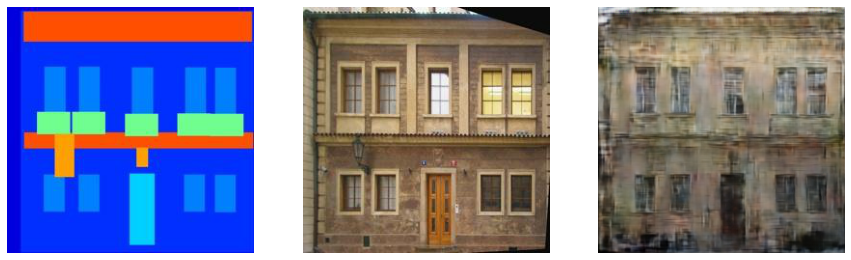

Epoch:  400
[step = 100] gen_loss: 2.733, disc_loss: 0.693
[step = 200] gen_loss: 2.570, disc_loss: 0.691

EPOCH = 400, gen_loss = 2.570, disc_loss = 0.691, val_gen_loss = 15.114, val_disc_loss = 1.397
Time taken for epoch 400 is 24.72894549369812 sec

Finished training...


In [34]:
#%pdb on
epochs = 400
dfhistory = train_model(generator,discriminator,dl_train,dl_val,epochs)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


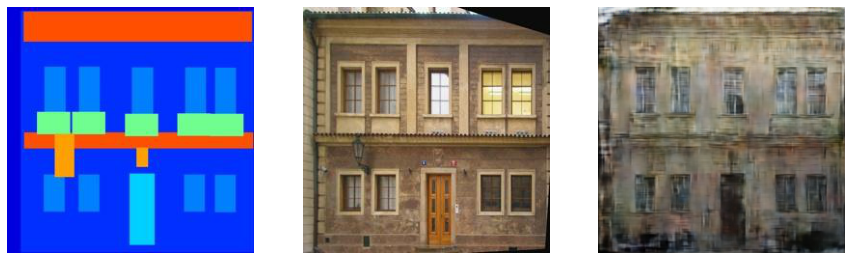

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


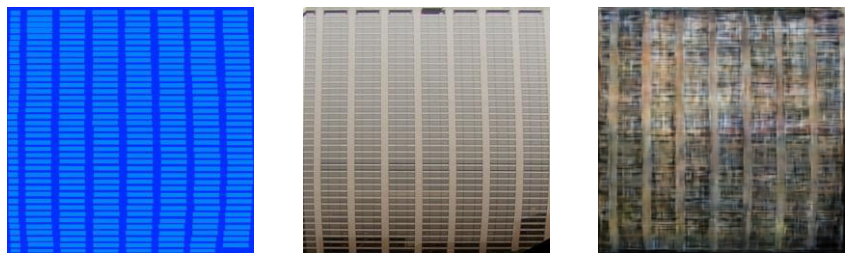

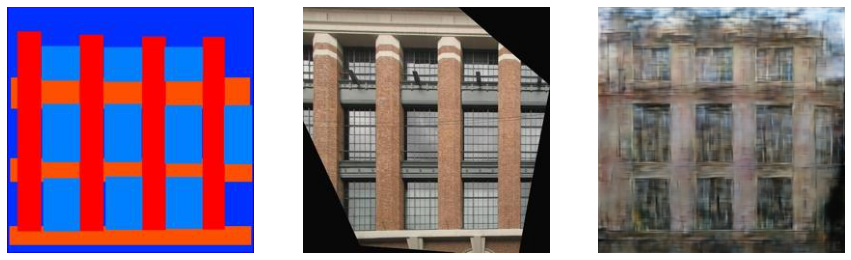

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


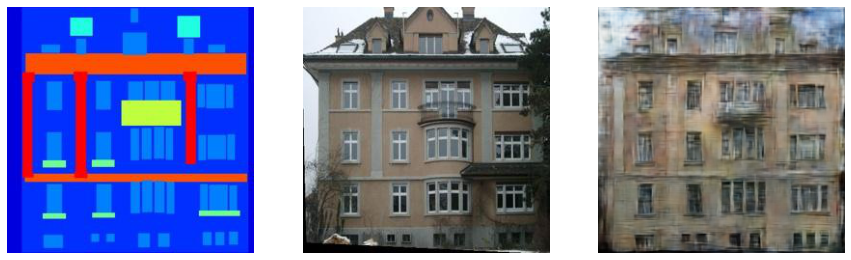

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


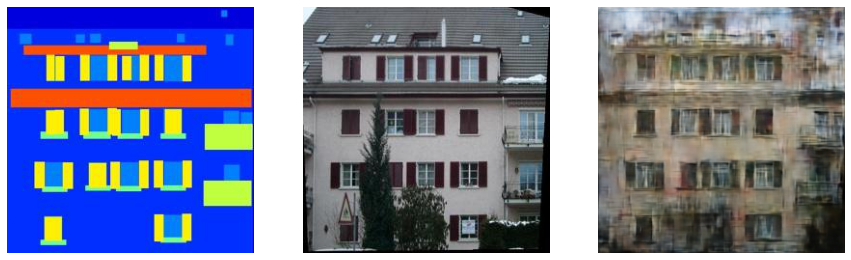

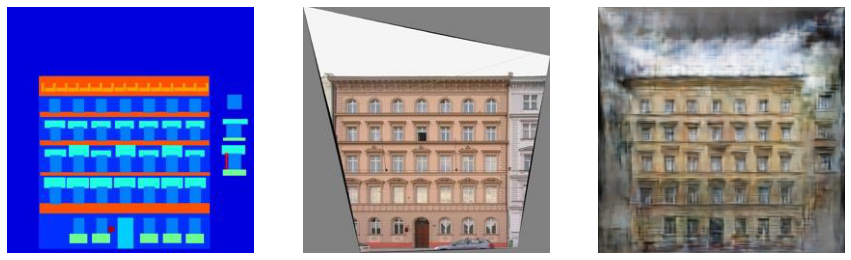

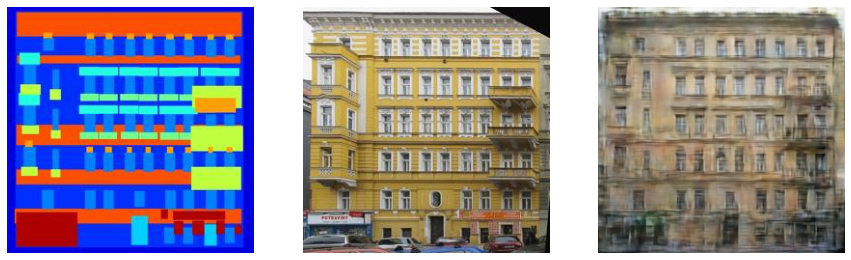

In [35]:
for idx, testpair in enumerate(dl_val):
  input,target = testpair['A'],testpair['B']
  generate_images(generator,input.to(device),target.to(device))
  if idx>5:
    break

In [37]:
dfhistory

epoch  gen_loss  disc_loss  val_gen_loss  val_disc_loss
0      1.0  6.594576   0.689309     16.105377       1.413255
1      2.0  7.213200   0.710702     15.603596       1.419267
2      3.0  7.328618   0.830903     15.122747       1.380839
3      4.0  6.697601   0.692361     15.883036       1.383993
4      5.0  6.549688   0.686673     15.092447       1.394918
..     ...       ...        ...           ...            ...
395  396.0  4.012899   0.693546     15.805615       1.386968
396  397.0  3.215135   0.693972     15.297809       1.393732
397  398.0  3.225648   0.687962     15.191504       1.393789
398  399.0  3.071788   0.694227     15.374930       1.388661
399  400.0  2.569823   0.691104     15.114100       1.396691

[400 rows x 5 columns]

In [40]:
torch.save(generator.state_dict(),'./generator_param.pkl')
torch.save(discriminator.state_dict(),'./discriminator_param.pkl')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


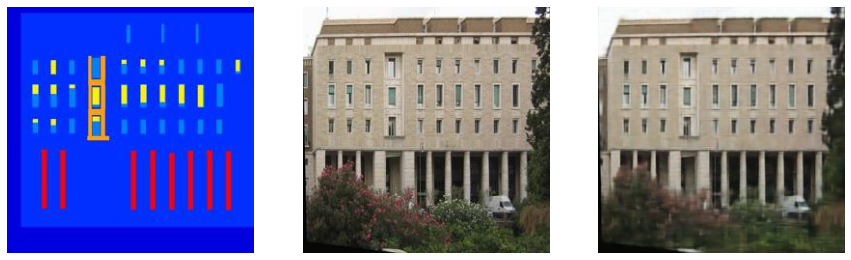

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


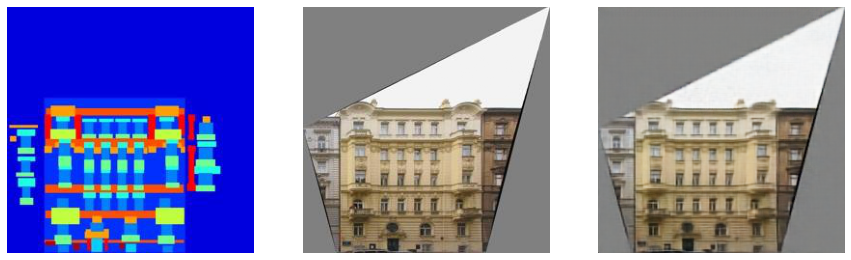

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


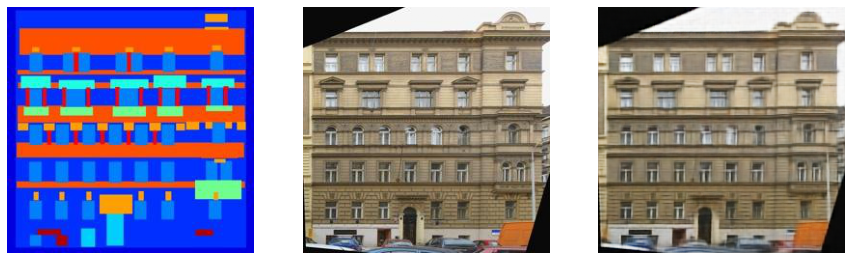

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


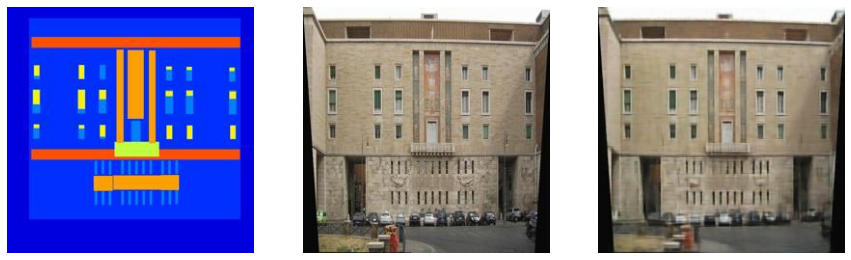

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


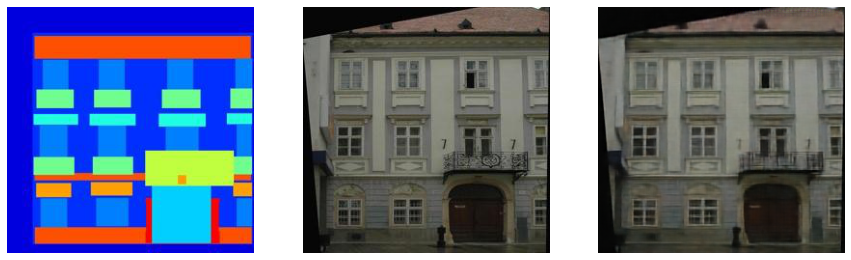

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


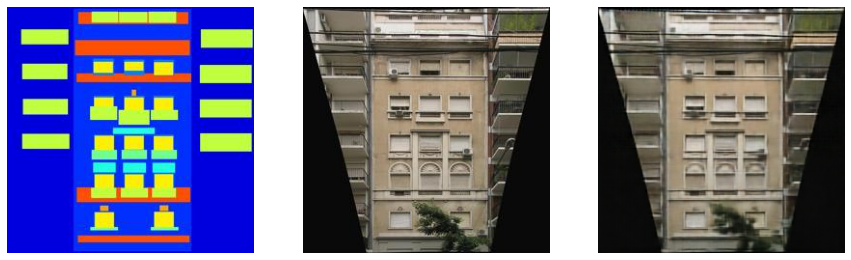

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


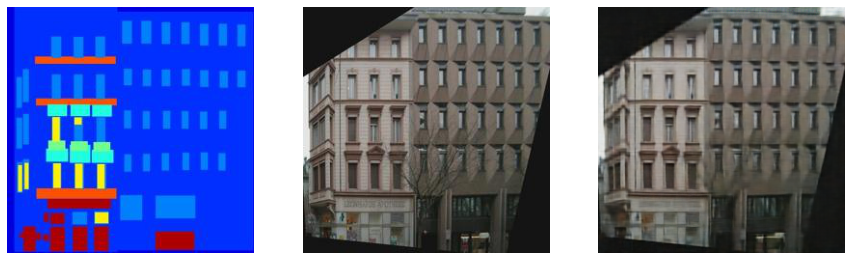

In [41]:
new_generator = Generator()
new_discriminator = Discriminator()

new_generator.load_state_dict(torch.load('./generator_param.pkl'))
new_discriminator.load_state_dict(torch.load('./discriminator_param.pkl'))

for idx, testpair in enumerate(dl_train):
  input,target = testpair['A'],testpair['B']
  generate_images(generator,input.to(device),target.to(device))
  if idx>5:
    break
